# 第10章 回帰分析 - 連続値を取る目的変数の予測

* https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch10/ch10.ipynb
* データセットの探索と可視化
* 線形回帰モデルを実装するための各種アプローチの考察
* 外れ値に対して頑健な回帰モデルのトレーニング
* 回帰モデルの評価と一般的な問題の診断
* 回帰モデルの非線形データでの学習

## 10.1 単純な線形回帰モデル

* 回帰直線: regression line
* オフセット: offcet
* 残差: residual
* 単回帰: simple linear regression
* 重回帰: multiple linear regression

## 10.2 Housing データセットの探索

* https://archive.ics.uci.edu/ml/datasets/Housing
* 1978年に収集されたボストン近郊の住宅情報
* 506 個のサンプルの特徴量

1. CRIM: 犯罪発生率(人口単位)
2. ZN: 25,000平方フィート以上の住宅区画の割合
3. INDUS: 非小売業の土地面積の割合(人口単位)
4. CHAS: チャールズ川沿いかどうか(川沿いは1 ,そうでない場合は0)
5. NOX: 窒素酸化物の濃度(pphm単位)
6. RM: 1戸あたりの平均部屋数
7. AGE: 1940年よりも前に建てられた家屋の割合
8. DIS: ボストンの主な5つの雇用圏までの重み付きの距離
9. RAD: 幹線道路へのアクセス指数
10. TAX: 10,000ドルあたりの所得税率
11. PTRATIO: 教師あたりの生徒の数(人口単位)
12. B: 1000(Bk - 0.63)^2 として計算: Bkはアフリカ系アメリカ人居住者の割合(人口単位)
13. LSTAT: 低所得者の割合
14. MEDV: 住宅価格の中央値(単位 1,000ドル)

In [1]:
import pandas as pd

# データを読むこむ
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data',
                 header=None,
                 sep='\s+')
df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


### 10.2.1 データセットの重要な特性を可視化する

* 探索的データ解析(Exploratory Data Analysis: EDA)

```
$ pip install seaborn
```

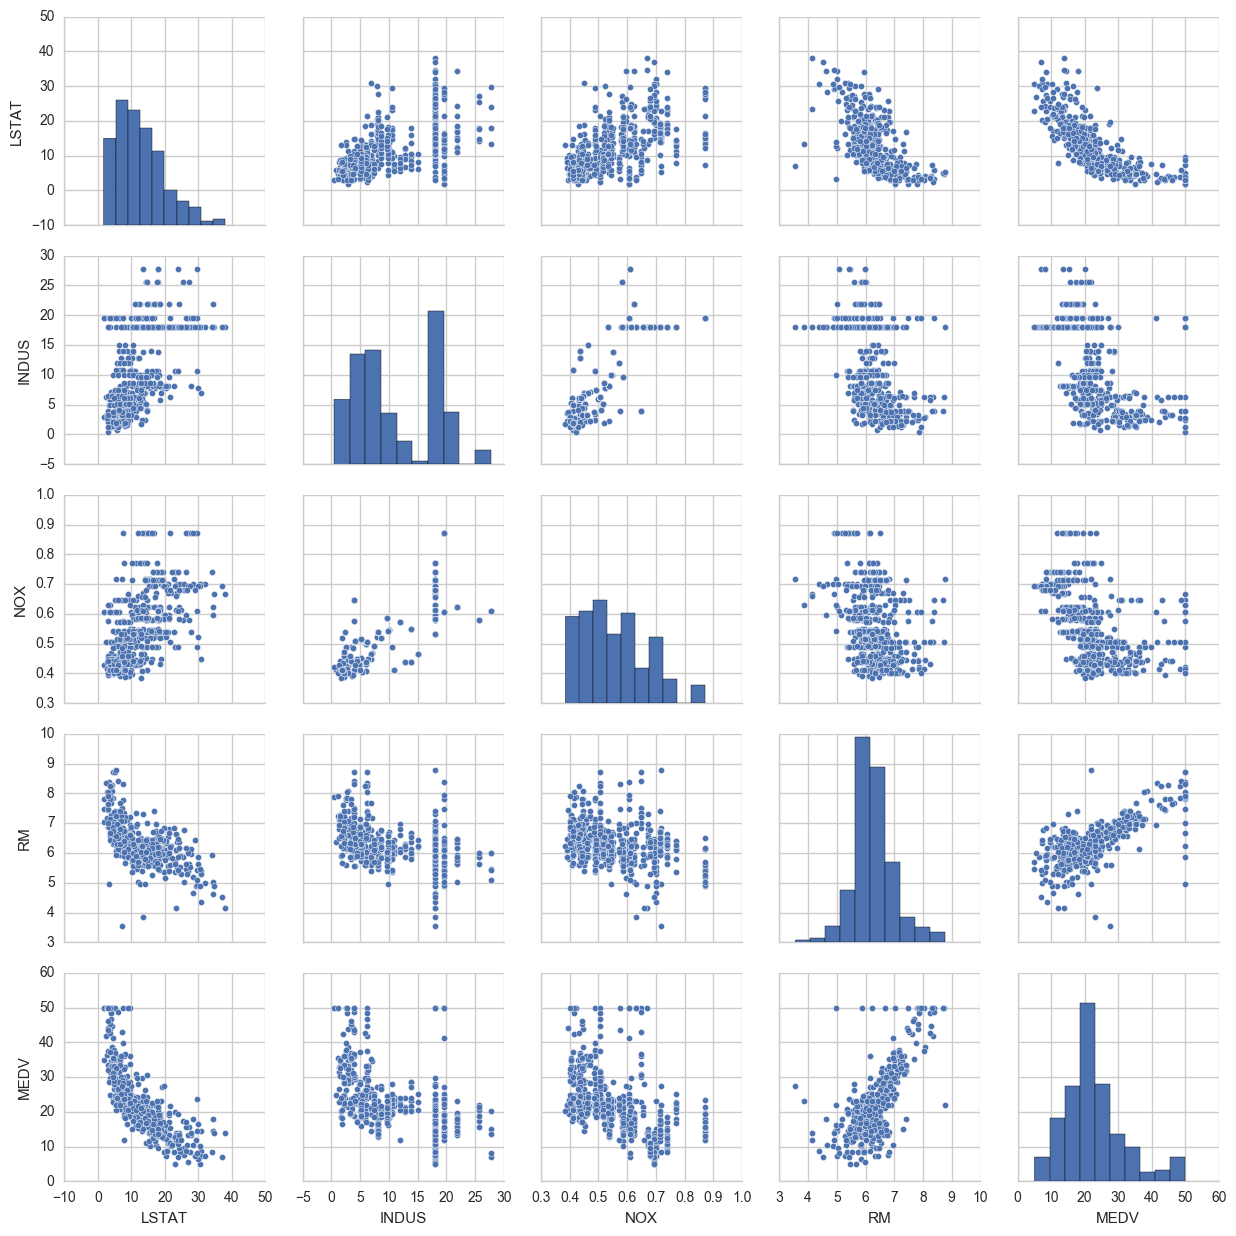

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# グラフのスタイルを指定
sns.set(style='whitegrid', context='notebook')
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']
# 変数のペアの関係をプロット
sns.pairplot(df[cols], size=2.5)
plt.show()

* ピアソンの積率相関係数(Pearson product-moment correlation coefficient)
* ピアソンのr(Pearons's r)

[[ 1.          0.60379972  0.59087892 -0.61380827 -0.73766273]
 [ 0.60379972  1.          0.76365145 -0.39167585 -0.48372516]
 [ 0.59087892  0.76365145  1.         -0.30218819 -0.42732077]
 [-0.61380827 -0.39167585 -0.30218819  1.          0.69535995]
 [-0.73766273 -0.48372516 -0.42732077  0.69535995  1.        ]]


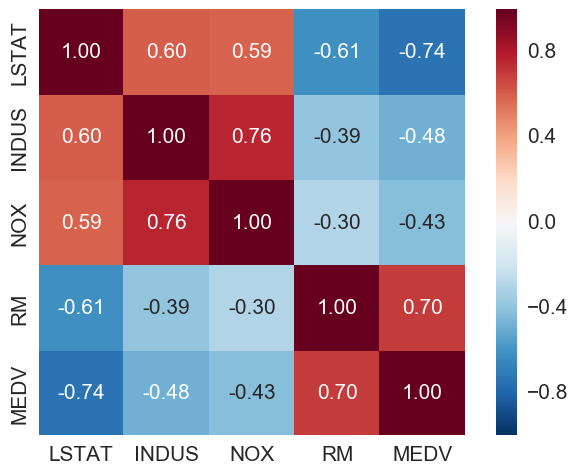

In [6]:
# 相関行列をヒートマップとしてプロットする
import numpy as np
cm = np.corrcoef(df[cols].values.T) # ピアソンの積率相関係数を計算
sns.set(font_scale=1.5)
print(cm)
hm = sns.heatmap(cm, # 第1引数の相関係数をもとにヒートマップを作成
                 cbar=True, # カラーバーの表示
                 annot=True, # データ値の表示
                 square=True, # 色矩形の正方形化
                 fmt='.2f', # 数値の表示形式
                 annot_kws={'size': 15}, # データ値のサイズの指定
                 yticklabels=cols, # 行のメモリのラベル名
                 xticklabels=cols) # 列のメモリのラベル名
plt.show()

## 10.3 最小二乗線形回帰モデルの実装

* 最小二乗法(Ordinary Least Squares: OLS)

### 10.3.1 勾配降下法を使って回帰パラメータの回帰を解く

* 勾配降下法(GD)
* 確率的勾配降下法(SGD)